# Object Detection and Depth Estimation

## Import Libraries

In [1]:
import os
import numpy as np
from PIL import Image, ImageDraw, ImageFont
from ultralytics import YOLO
import matplotlib.pyplot as plt

## Function Definitions

In [2]:
# Function to calculate IoU (Intersection over Union)
def calculate_iou(box1, box2):
    # Calculate intersection coordinates
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])

    # Calculate intersection area
    intersection_area = max(0, x2 - x1 + 1) * max(0, y2 - y1 + 1)
    # Calculate areas of both bounding boxes
    area_box1 = (box1[2] - box1[0] + 1) * (box1[3] - box1[1] + 1)
    area_box2 = (box2[2] - box2[0] + 1) * (box2[3] - box2[1] + 1)
    # Calculate union area
    union_area = area_box1 + area_box2 - intersection_area
    # Calculate IoU
    iou = intersection_area / union_area
    
    return iou

# Function to convert pixel coordinates to 3D world coordinates
def convert_to_3D(pixel_coordinate, K_inv, scalar):
    pixel_homogeneous = np.append(pixel_coordinate, 1).reshape(3, 1)
    ray_direction = np.dot(K_inv, pixel_homogeneous)
    point_3D = scalar * ray_direction.flatten()
    
    return point_3D

# Function to calculate real-world distance using 3D conversion
def calculate_real_world_distance_3D_conversion(bottom_center, K, camera_height):
    fx, fy, cx, cy = K[0, 0], K[1, 1], K[0, 2], K[1, 2]
    K_inv = np.linalg.inv(K)
    real_world_Z = camera_height * fy / (bottom_center[1] - cy)
    bottom_center_3D = convert_to_3D(bottom_center, K_inv, real_world_Z)
    distance = np.linalg.norm(bottom_center_3D)
    
    return distance

## File indices

In [3]:
file_indices = [
    '006037', '006042', '006048', '006054', '006059', '006067',
    '006097', '006098', '006211', '006227', '006253', '006291',
    '006310', '006312', '006315', '006329', '006374'
]

## Object Detection by YOLO v8

In [4]:
# Define YOLO model
model = YOLO("yolov8x.pt")  # Adjust to your preferred model


image 1/1 c:\Users\mistr\Desktop\task02\KITTI_Selection\images\006037.png: 224x640 9 cars, 519.2ms
Speed: 0.0ms preprocess, 519.2ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 640)

image 1/1 c:\Users\mistr\Desktop\task02\KITTI_Selection\images\006042.png: 224x640 3 cars, 1 parking meter, 500.3ms
Speed: 0.6ms preprocess, 500.3ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 640)

image 1/1 c:\Users\mistr\Desktop\task02\KITTI_Selection\images\006048.png: 224x640 1 person, 8 cars, 2 trucks, 478.3ms
Speed: 0.0ms preprocess, 478.3ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 640)

image 1/1 c:\Users\mistr\Desktop\task02\KITTI_Selection\images\006054.png: 224x640 13 cars, 1 truck, 469.4ms
Speed: 0.0ms preprocess, 469.4ms inference, 5.5ms postprocess per image at shape (1, 3, 224, 640)

image 1/1 c:\Users\mistr\Desktop\task02\KITTI_Selection\images\006059.png: 224x640 1 person, 8 cars, 1 traffic light, 457.9ms
Speed: 5.7ms preprocess, 457.9ms i

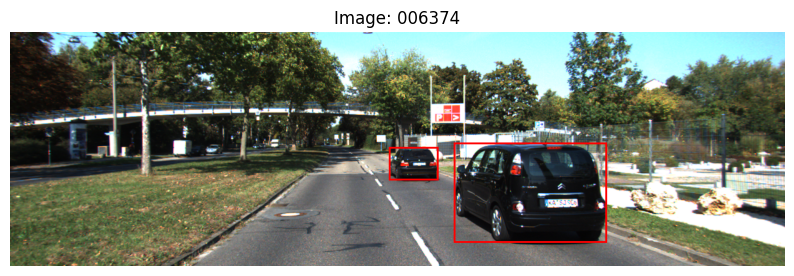

In [7]:
# Create output directory if it doesn't exist
output_dir = "./yolo_output"
os.makedirs(output_dir, exist_ok=True)

# Process each file
for file_index in file_indices:
    # Load the ground truth bounding boxes
    gt_boxes = np.loadtxt(f"./KITTI_Selection/labels/{file_index}.txt", usecols=(1, 2, 3, 4)).tolist()

    # Path to the image
    img_path = f"./KITTI_Selection/images/{file_index}.png"

    # Object detection
    results = model.predict(
        source=img_path,
        conf=0.25,  # Confidence threshold
        augment=True,  # Data augmentation
    )

    # Extract detection results
    boxes = results[0].boxes.xyxy.tolist()
    confidences = results[0].boxes.conf.tolist()

    # Filter out detections based on IoU with ground truth boxes
    filtered_boxes = []
    for box, conf in zip(boxes, confidences):
        x1, y1, x2, y2 = box
        detected_box = [x1, y1, x2, y2]
        max_iou = max([calculate_iou(detected_box, gt_box) for gt_box in gt_boxes])
        if max_iou >= 0.45:
            filtered_boxes.append(box)

    # Save filtered bounding box coordinates
    output_file = f"./bounding_box_coordinates/{file_index}.txt"
    with open(output_file, 'w') as f:
        for box in filtered_boxes:
            x1, y1, x2, y2 = box
            f.write(f"{x1} {y1} {x2} {y2}\n")
    
    """"
    # Create combined image with YOLO and ground truth boxes
    image_combined = Image.fromarray(results[0].plot()[:, :, ::-1])
    draw = ImageDraw.Draw(image_combined)
    for gt_box in gt_boxes:
        x1, y1, x2, y2 = gt_box
        draw.rectangle([x1, y1, x2, y2], outline="green", width=3)

    # Save combined image
    image_combined.save(os.path.join(output_dir, f"{file_index}_combined.png"))
    """
    
    # Create filtered YOLO detection image
    image_filtered = Image.open(img_path)
    draw = ImageDraw.Draw(image_filtered)
    for box in filtered_boxes:
        x1, y1, x2, y2 = box
        draw.rectangle([x1, y1, x2, y2], outline="red", width=3)

    # Save filtered detection image
    image_filtered.save(os.path.join(output_dir, f"{file_index}_filtered.png"))

# Display the last processed combined image in the Jupyter Notebook
plt.figure(figsize=(10, 10))
plt.imshow(image_filtered)
plt.axis('off')
plt.title(f"Image: {file_index}")
plt.show()

## Calculate distance using coordinates of Bounding Box from YOLO

In [8]:
for i in file_indices:
    # Load calibration matrix
    calib_path = f"./KITTI_Selection/calib/{i}.txt"
    calib = np.loadtxt(calib_path)  # Load the calibration matrix from file

    # Define camera height
    camera_height = 1.65  # meters

    # Load bounding box coordinates from file
    bb_path = f"./bounding_box_coordinates/{i}.txt"
    bb_coords = np.loadtxt(bb_path, usecols=(0,1, 2, 3), dtype='float')

    # Calculate distances for each bounding box using 3D conversion method
    distances_3D_conversion = []
    for bbox in bb_coords:
        x1, y1, x2, y2 = bbox
        bottom_center = [(x1 + x2) / 2, y2]  # Calculate bottom center of bounding box
        distance = calculate_real_world_distance_3D_conversion(bottom_center, calib, camera_height)
        distances_3D_conversion.append(distance)

    # Save distances in the 5th column of the bounding box files
    output_file = f"./bounding_box_coordinates/{i}.txt"
    with open(output_file, 'r') as f:
        lines = f.readlines()

    with open(output_file, 'w') as f:
        for line, distance in zip(lines, distances_3D_conversion):
            line = line.strip()  # Remove trailing newline
            f.write(f"{line} {distance:.2f}\n")  # Append the distance in the 5th column

    """# Print distances using 3D conversion method
    for j, distance in enumerate(distances_3D_conversion, start=1):
        print(f"Distance to object {j} in image {i}: {distance:.2f} meters")"""


## Display the YOLO distances with the actual distances in images

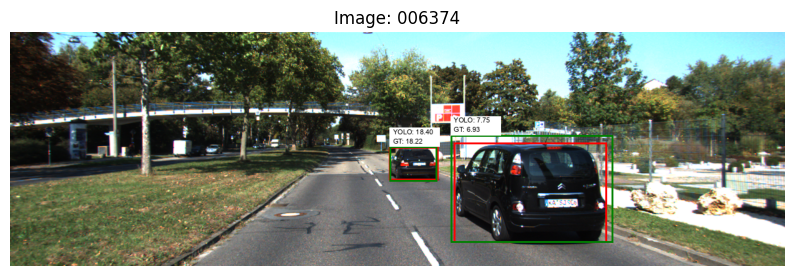

In [13]:
# Define font settings
font_path = "arial.ttf"  # Path to the Arial font file
font_size = 11
font = ImageFont.truetype(font_path, font_size)

# Iterate over each file
for file_name in file_indices:
    # Load the image
    img_path = f"./KITTI_Selection/images/{file_name}.png"
    image = Image.open(img_path)
    draw = ImageDraw.Draw(image)

    # Load YOLO bounding box coordinates and distances from file
    yolo_bbox_file_path = f"./bounding_box_coordinates/{file_name}.txt"
    yolo_bounding_boxes = []
    with open(yolo_bbox_file_path, 'r') as f:
        for line in f:
            values = line.strip().split(' ')
            if len(values) == 5:  # Ensure line has 5 values
                x1, y1, x2, y2, distance = map(float, values)
                yolo_bounding_boxes.append(((x1, y1), (x2, y2), distance))

    # Load ground truth bounding box coordinates and distances from label file
    gt_bbox_file_path = f"./KITTI_Selection/labels/{file_name}.txt"
    gt_bounding_boxes = []
    with open(gt_bbox_file_path, 'r') as f:
        for line in f:
            values = line.strip().split(' ')
            if len(values) == 6:  # Ensure line has 6 values (skip class name)
                _, x1, y1, x2, y2, distance = values
                gt_bounding_boxes.append(((float(x1), float(y1), float(x2), float(y2)), float(distance)))

    # Draw bounding boxes and display distances
    for i, (yolo_bbox, gt_bbox) in enumerate(zip(yolo_bounding_boxes, gt_bounding_boxes)):
        (x1, y1), (x2, y2), yolo_distance = yolo_bbox
        (gt_x1, gt_y1, gt_x2, gt_y2), gt_distance = gt_bbox

        # Draw YOLO bounding box
        draw.rectangle([(x1, y1), (x2, y2)], outline="red", width=3)

        # Draw GT bounding box
        draw.rectangle([(gt_x1, gt_y1), (gt_x2, gt_y2)], outline="green", width=3)

        # Create a white filled rectangle at the top-left corner of the GT bounding box
        text_box_start_x, text_box_start_y = gt_x1, gt_y1 - 30
        text_box_end_x, text_box_end_y = text_box_start_x + 80, text_box_start_y + 30
        draw.rectangle([(text_box_start_x, text_box_start_y), (text_box_end_x, text_box_end_y)], fill=(255, 255, 255))

        # Display both YOLO and GT distances in the white box
        draw.text((text_box_start_x + 5, text_box_start_y), f"YOLO: {yolo_distance:.2f}", fill="black", font=font)
        draw.text((text_box_start_x + 5, text_box_start_y + 15), f"GT: {gt_distance:.2f}", fill="black", font=font)

    # Save the annotated image
    annotated_img_path = f"./results/{file_name}_annotated.png"
    image.save(annotated_img_path)
    
# Display the last processed combined image in the Jupyter Notebook
plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.axis('off')
plt.title(f"Image: {file_index}")
plt.show()

## Scatter plot to compare the YOLO distances with the actual distances

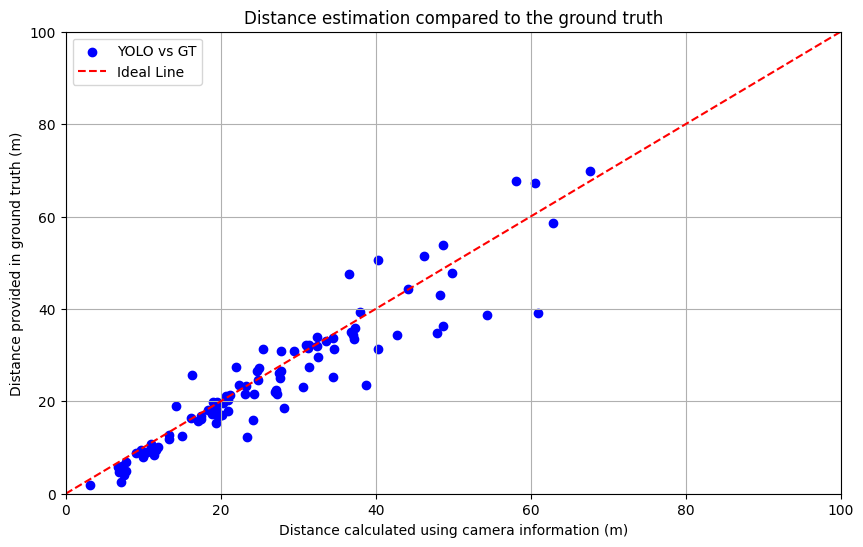

In [14]:
# Initialize lists to store distances for plotting
all_gt_distances = []
all_yolo_distances = []

# Iterate over each file index
for idx in file_indices:
    # Load YOLO distances
    bb_path = f"./bounding_box_coordinates/{idx}.txt"
    bb_coords_with_distances = np.loadtxt(bb_path, usecols=(4,), dtype='float', ndmin=1)

    # Load ground truth distances
    gt_path = f"./KITTI_Selection/labels/{idx}.txt"
    gt_coords = np.loadtxt(gt_path, usecols=(5,), dtype='float', ndmin=1)

    # Ensure both arrays have the same size
    if len(bb_coords_with_distances) == len(gt_coords):
        # Append distances for plotting
        all_yolo_distances.extend(bb_coords_with_distances)
        all_gt_distances.extend(gt_coords)
    else:
        print(f"Warning: Mismatched sizes in file {idx}")

# Convert to numpy arrays for plotting
all_gt_distances = np.array(all_gt_distances)
all_yolo_distances = np.array(all_yolo_distances)

# Plot ground truth vs YOLO distances
plt.figure(figsize=(10, 6))
plt.scatter(all_yolo_distances, all_gt_distances, color='blue', label='YOLO vs GT')
plt.plot([0, 100], [0, 100], color='red', linestyle='--', label='Ideal Line')
plt.xlabel('Distance calculated using camera information (m)')
plt.ylabel('Distance provided in ground truth (m)')
plt.title('Distance estimation compared to the ground truth')
plt.xticks(np.arange(0, 101, 20))
plt.yticks(np.arange(0, 101, 20))
plt.xlim(0, 100)
plt.ylim(0, 100)
plt.legend()
plt.grid(True)
plt.show()